# Aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile, orm

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
from workflow import (
    generate_structures,
    get_bulk_structure,
    calculate_qe as _calculate_qe,
    plot_energy_volume_curve,
)

In [4]:
calculate_qe = task(outputs=["energy", "volume", "structure"])(_calculate_qe)

In [5]:
wg = WorkGraph("wg-qe")

### Prepare the inputs

In [6]:
element = orm.Str("Al")
a = orm.Float(4.04)
cubic = orm.Bool(True)
relax_workdir = orm.Str("mini")
pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
kpts = orm.List([3, 3, 3])
calc_type_relax = orm.Str("vc-relax")
calc_type_scf = orm.Str("scf")
smearing = orm.Float(0.02)
strain_lst = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])

### Actual tasks to construct the EOS workflow

In [7]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    element=element,
    a=a,
    cubic=cubic,
)

In [8]:
relax_prepare_input_dict_task = wg.add_task(
    get_dict,
    structure=get_bulk_structure_task.outputs.result,
    calculation=calc_type_relax,
    kpts=kpts,
    pseudopotentials=pseudopotentials,
    smearing=smearing,
)

relax_task = wg.add_task(
    calculate_qe,
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=relax_workdir,
)

In [9]:
generate_structures_task = wg.add_task(
    generate_structures,
    structure=relax_task.outputs.structure,
    strain_lst=strain_lst,
)

In [10]:
get_volumes_task = wg.add_task(get_list)

In [11]:
get_energies_task = wg.add_task(get_list)

In [12]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = orm.Str(f"strain_{i}")
    generate_structures_task.add_output("workgraph.any", structure_key)

    scf_prepare_input_dict_task = wg.add_task(
        get_dict,
        structure=generate_structures_task.outputs[structure_key],
        calculation=calc_type_scf,
        kpts=kpts,
        pseudopotentials=pseudopotentials,
        smearing=smearing,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [13]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [15]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [16]:
!cat {workflow_json_filename}

{
  "version": "0.1.0",
  "nodes": [
    {
      "id": 0,
      "type": "function",
      "value": "workflow.get_bulk_structure"
    },
    {
      "id": 1,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 2,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 3,
      "type": "function",
      "value": "workflow.generate_structures"
    },
    {
      "id": 4,
      "type": "function",
      "value": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 5,
      "type": "function",
      "value": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 6,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "type": "function",
      "value": "workflow.calculate_qe"
    },
    {
      "id": 8,
      "type": "function",
      "value": "python_workflow_definition.shared.get_dict"
    },
    {
  

## Load Workflow with jobflow

In [17]:
from python_workflow_definition.jobflow import load_workflow_json

In [18]:
from jobflow.managers.local import run_locally

In [19]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [20]:
flow[0].function_kwargs["a"] = 4.05

2025-05-26 04:52:50,581 INFO Started executing jobs locally
2025-05-26 04:52:50,675 INFO Starting job - get_bulk_structure (3ac8790d-eb22-4532-be62-de8fbef1b1d6)
2025-05-26 04:52:50,678 INFO Finished job - get_bulk_structure (3ac8790d-eb22-4532-be62-de8fbef1b1d6)
2025-05-26 04:52:50,678 INFO Starting job - get_dict (c4961244-74bf-450f-8d51-1185a6fa636e)
2025-05-26 04:52:50,679 INFO Finished job - get_dict (c4961244-74bf-450f-8d51-1185a6fa636e)
2025-05-26 04:52:50,680 INFO Starting job - calculate_qe (1c454eb0-0ad4-4b71-9d98-9d767f2eeb26)


[jupyter-pythonworkflow-fl--x---218119f8:02130] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-26 04:53:41,492 INFO Finished job - calculate_qe (1c454eb0-0ad4-4b71-9d98-9d767f2eeb26)
2025-05-26 04:53:41,493 INFO Starting job - generate_structures (4b55ebda-5c1f-4778-96b0-04b01637fd55)
2025-05-26 04:53:41,497 INFO Finished job - generate_structures (4b55ebda-5c1f-4778-96b0-04b01637fd55)
2025-05-26 04:53:41,498 INFO Starting job - get_dict (b565cdc4-4ce6-4a26-80aa-df13d5c66c6a)
2025-05-26 04:53:41,501 INFO Finished job - get_dict (b565cdc4-4ce6-4a26-80aa-df13d5c66c6a)
2025-05-26 04:53:41,502 INFO Starting job - get_dict (b77d779a-5ef4-444f-be7e-386f16f7ec4a)
2025-05-26 04:53:41,505 INFO Finished job - get_dict (b77d779a-5ef4-444f-be7e-386f16f7ec4a)
2025-05-26 04:53:41,506 INFO Starting job - get_dict (bd7706a1-7c30-4c5c-9319-a082dc3950ad)
2025-05-26 04:53:41,509 INFO Finished job - get_dict (bd7706a1-7c30-4c5c-9319-a082dc3950ad)
2025-05-26 04:53:41,510 INFO Starting job - get_dict (05f7faac-40ed-495e-b0dc-26ba16f805c8)
2025-05-26 04:53:41,513 INFO Finished job - get_dict (

[jupyter-pythonworkflow-fl--x---218119f8:02145] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:53:51,562 INFO Finished job - calculate_qe (45551771-435e-4dc6-913f-07091732e0a3)
2025-05-26 04:53:51,563 INFO Starting job - calculate_qe (548d3d66-855c-45f6-803d-894aaf90fd6b)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02155] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:54:02,977 INFO Finished job - calculate_qe (548d3d66-855c-45f6-803d-894aaf90fd6b)
2025-05-26 04:54:02,978 INFO Starting job - calculate_qe (d309162b-9af7-4270-bfd5-fc0c893ba9f0)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02165] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:54:14,530 INFO Finished job - calculate_qe (d309162b-9af7-4270-bfd5-fc0c893ba9f0)
2025-05-26 04:54:14,531 INFO Starting job - calculate_qe (67abe614-2777-4184-92e6-f5443def6503)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02175] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:54:27,806 INFO Finished job - calculate_qe (67abe614-2777-4184-92e6-f5443def6503)
2025-05-26 04:54:27,807 INFO Starting job - calculate_qe (35826c86-14ca-4341-90f0-894b9be0d16d)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02185] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-05-26 04:54:41,828 INFO Finished job - calculate_qe (35826c86-14ca-4341-90f0-894b9be0d16d)
2025-05-26 04:54:41,829 INFO Starting job - get_list (87cd2e29-15fc-4e35-845f-47211f6a1090)
2025-05-26 04:54:41,835 INFO Finished job - get_list (87cd2e29-15fc-4e35-845f-47211f6a1090)
2025-05-26 04:54:41,836 INFO Starting job - get_list (3b0846af-d37d-4199-897b-16f124a5516a)
2025-05-26 04:54:41,839 INFO Finished job - get_list (3b0846af-d37d-4199-897b-16f124a5516a)
2025-05-26 04:54:41,840 INFO Starting job - plot_energy_volume_curve (88a18290-ffeb-40b6-b0e8-fca1ee6fade4)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-05-26 04:54:41,900 INFO Finished job - plot_energy_volume_curve (88a18290-ffeb-40b6-b0e8-fca1ee6fade4)
2025-05-26 04:54:41,901 INFO Finished executing jobs locally


{'3ac8790d-eb22-4532-be62-de8fbef1b1d6': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

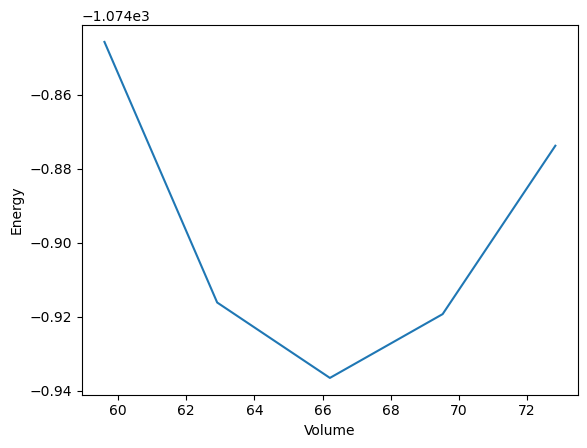

In [21]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

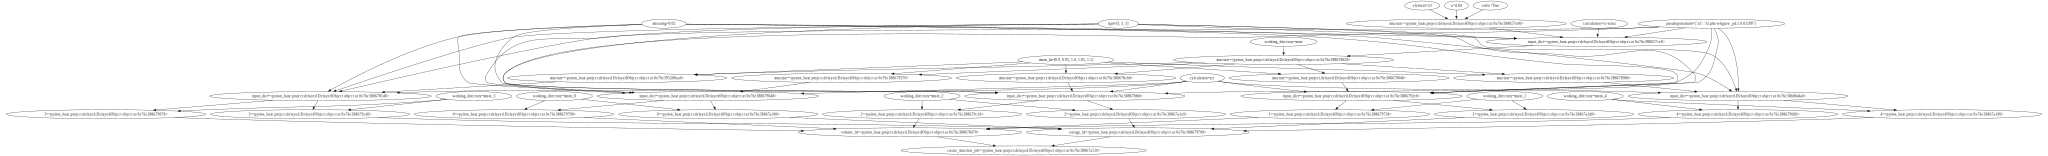

In [23]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [24]:
delayed_object_lst[0].input['a'] = 4.05

The job get_bulk_structure_2ca4aeae204ceaa28593c93054b07908 was saved and received the ID: 1
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 2
The job calculate_qe_b261e97e2e1714bf57ce6e5016ae4632 was saved and received the ID: 3


[jupyter-pythonworkflow-fl--x---218119f8:02215] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_4ebba2fa25817e4d72c841e3b2e8b6f0 was saved and received the ID: 4
The job get_dict_869b937d7880c2f0aa7d1ff12e5658fe was saved and received the ID: 5
The job calculate_qe_1e1d1a32203e271ae2255924d3e9b14f was saved and received the ID: 6


[jupyter-pythonworkflow-fl--x---218119f8:02247] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_afe14b210783e4e61e6d468d63799bad was saved and received the ID: 7
The job calculate_qe_0c07010ebc24b938a57832c41fcd74af was saved and received the ID: 8


[jupyter-pythonworkflow-fl--x---218119f8:02261] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_c42b900d2b5d0c900d1158c58ab1a259 was saved and received the ID: 9
The job calculate_qe_808bdd6630f3c0da564a58075a232427 was saved and received the ID: 10


[jupyter-pythonworkflow-fl--x---218119f8:02271] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_db89bfa1573064c1e658fee65739f0d7 was saved and received the ID: 11
The job calculate_qe_91a59b931c007125c72d9a407632de03 was saved and received the ID: 12


[jupyter-pythonworkflow-fl--x---218119f8:02281] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_8e6eb778e855d484b1763a645b753abf was saved and received the ID: 13
The job calculate_qe_80b6905597629098e2dca3067098d3e9 was saved and received the ID: 14


[jupyter-pythonworkflow-fl--x---218119f8:02295] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_befc04228af2690aa933355368b2374b was saved and received the ID: 15
The job get_list_de1f227902310f2b34d080eff15204c9 was saved and received the ID: 16
The job plot_energy_volume_curve_a817e1974411e9ad4e1c06ce96b8a65d was saved and received the ID: 17


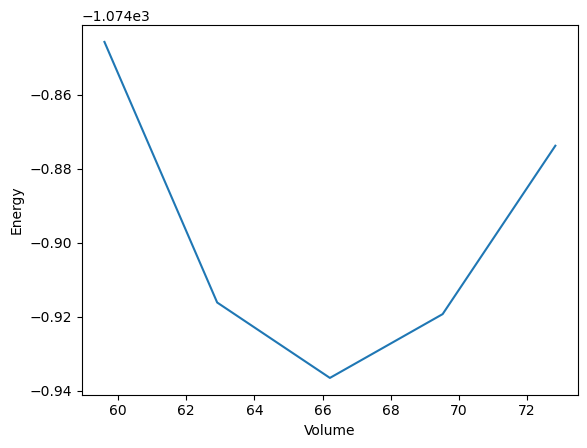

In [25]:
delayed_object_lst[-1].pull()

## Load Workflow with pyiron_workflow

In [26]:
from python_workflow_definition.pyiron_workflow import load_workflow_json

In [27]:
wf = load_workflow_json(file_name=workflow_json_filename)

In [28]:
wf.get_bulk_structure.inputs.a.value = 4.05

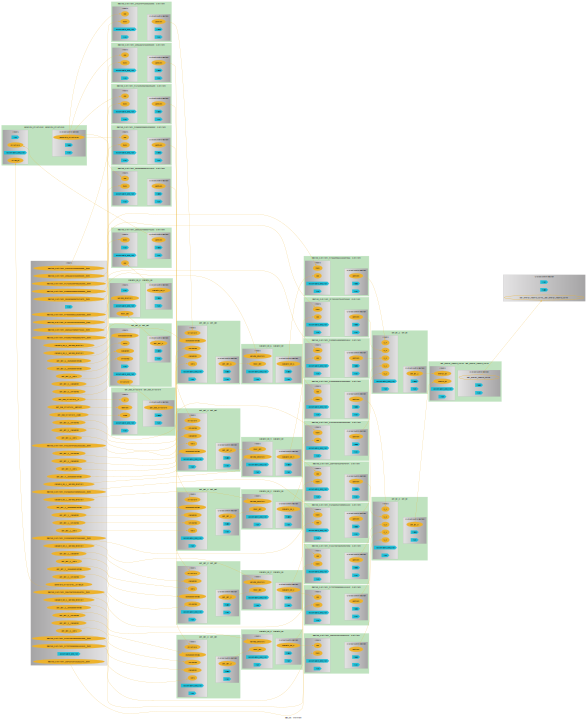

In [29]:
wf.draw(size=(10,10))

[jupyter-pythonworkflow-fl--x---218119f8:02308] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02404] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02421] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pythonworkflow-fl--x---218119f8:02443] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: 

{'plot_energy_volume_curve__plot_energy_volume_curve': None}

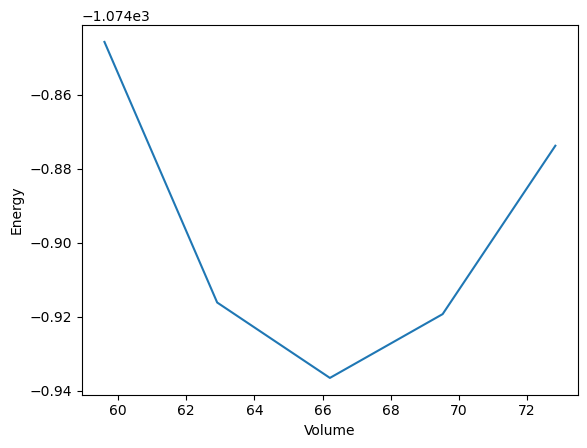

In [30]:
wf.run()